In [1]:
import os
import cv2
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_data(data_dir):
    data = []
    for index, label in enumerate(labels):
        path = os.path.join(data_dir, label)
        for img in os.listdir(path):
            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            resized_arr = cv2.resize(img_arr, (img_size, img_size))
            data.append([resized_arr, index])
    return np.array(data)

In [3]:
train = get_data('./chest_xray/train')
test = get_data('./chest_xray/test')
val = get_data('./chest_xray/val')

print(len(train))
print(len(test))
print(len(val))

C:\Users\VIJUL\AppData\Local\Temp/ipykernel_19276/268786122.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


5216
624
16


In [4]:
# Data Preprocessing and Data Augmentation

x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [5]:
# NORMALIZE THE DATA
# ======================
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

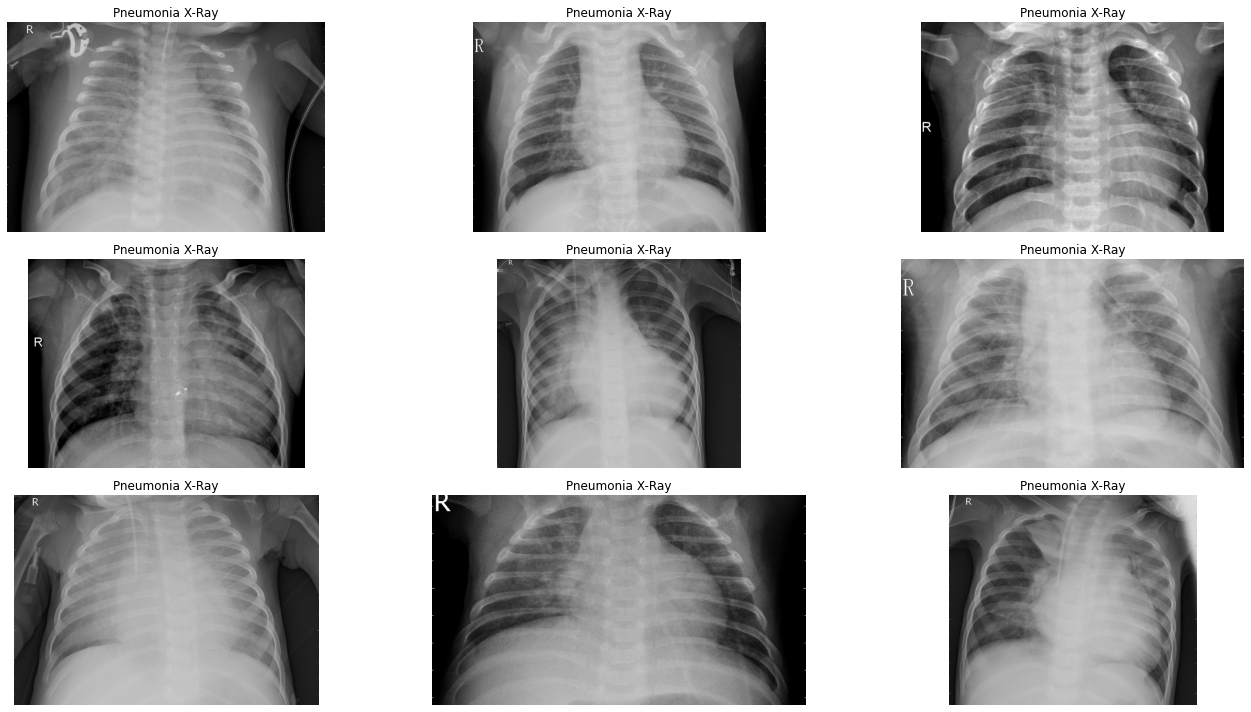

In [6]:
# Let's check out the dataset we're working on by picking out images of two data points from the dataset.
pneumonia = os.listdir("chest_xray/train/PNEUMONIA")
pneumonia_dir = "chest_xray/train/PNEUMONIA"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Pneumonia X-Ray") 
plt.tight_layout()

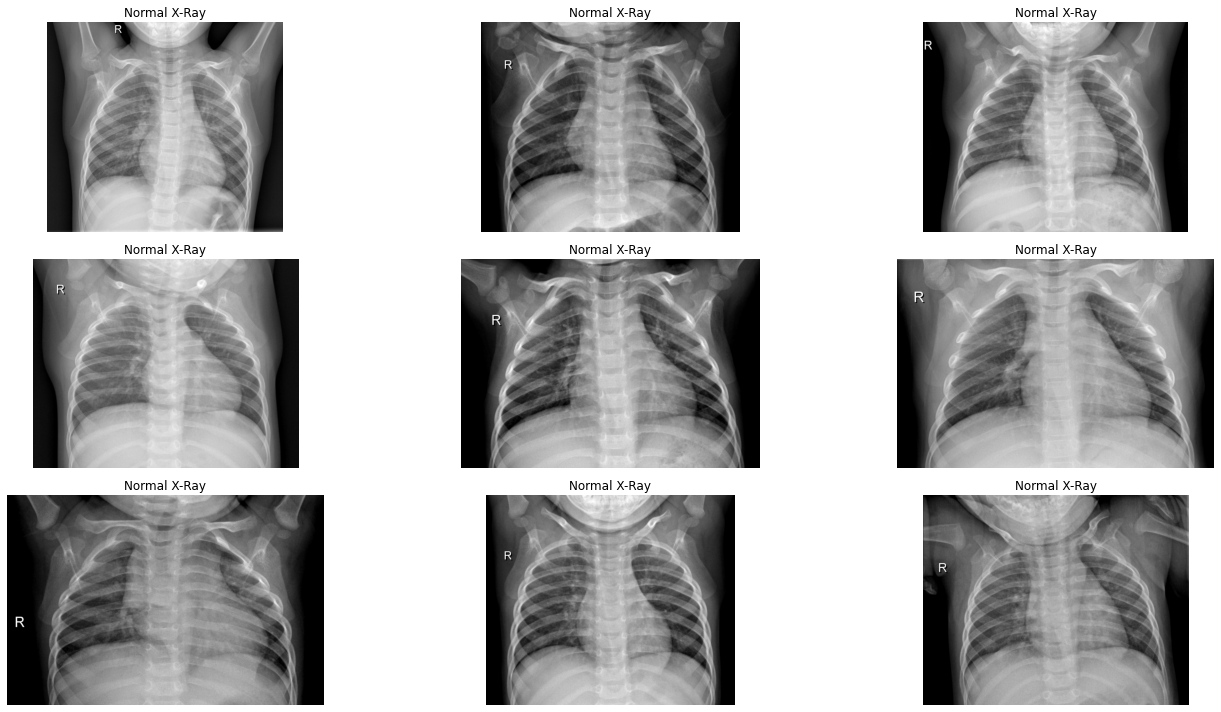

In [7]:
normal = os.listdir("chest_xray/train/NORMAL")
normal_dir = "chest_xray/train/NORMAL"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Normal X-Ray") 
   
plt.tight_layout()

C:\Users\VIJUL\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

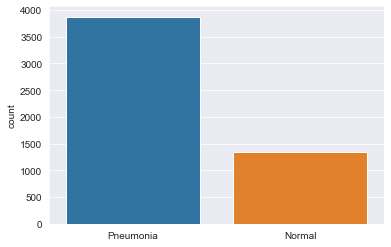

In [8]:
# check out the number of data points we are working with in the dataset
list = []
for i in train:
    if(i[1] == 0):
        list.append("Pneumonia")
    else:
        list.append("Normal")
sns.set_style('darkgrid')
sns.countplot(list)   

In [9]:
# Data Augmentation:
# In order to avoid overfitting problem, we need to expand artificially our dataset. We alter the training data with small transformations to reproduce the variations. Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

# Here:
# Randomly rotate some training images by 30 degrees
# Randomly Zoom by 20% some training images
# Randomly shift images horizontally by 10% of the width
# Randomly shift images vertically by 10% of the height
# Randomly flip images horizontally.

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False # randomly flip images
)

datagen.fit(x_train)

In [10]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))

model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))

model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))

model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())

model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))

model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [12]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 185s 1s/step - loss: 0.5908 - accuracy: 0.8345 - val_loss: 28.9801 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 176s 1s/step - loss: 0.2914 - accuracy: 0.8946 - val_loss: 24.4483 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - 177s 1s/step - loss: 0.2276 - accuracy: 0.9202 - val_loss: 3.9804 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 4/12
163/163 [==============================] - 164s 1s/step - loss: 0.2097 - accuracy: 0.9241 - val_loss: 29.1793 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/12
163/163 [==============================] - ETA: 0s - loss: 0.1979 - accuracy: 0.9333
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 154s 943ms/step - loss: 0.1979 - accuracy: 0.9333 - val_loss: 1.6076 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/12
163/163 [=============================

In [13]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 4s 186ms/step - loss: 0.3023 - accuracy: 0.8574
Loss of the model is -  0.3023321032524109
20/20 [==============================] - 4s 187ms/step - loss: 0.3023 - accuracy: 0.8574
Accuracy of the model is -  85.73718070983887 %


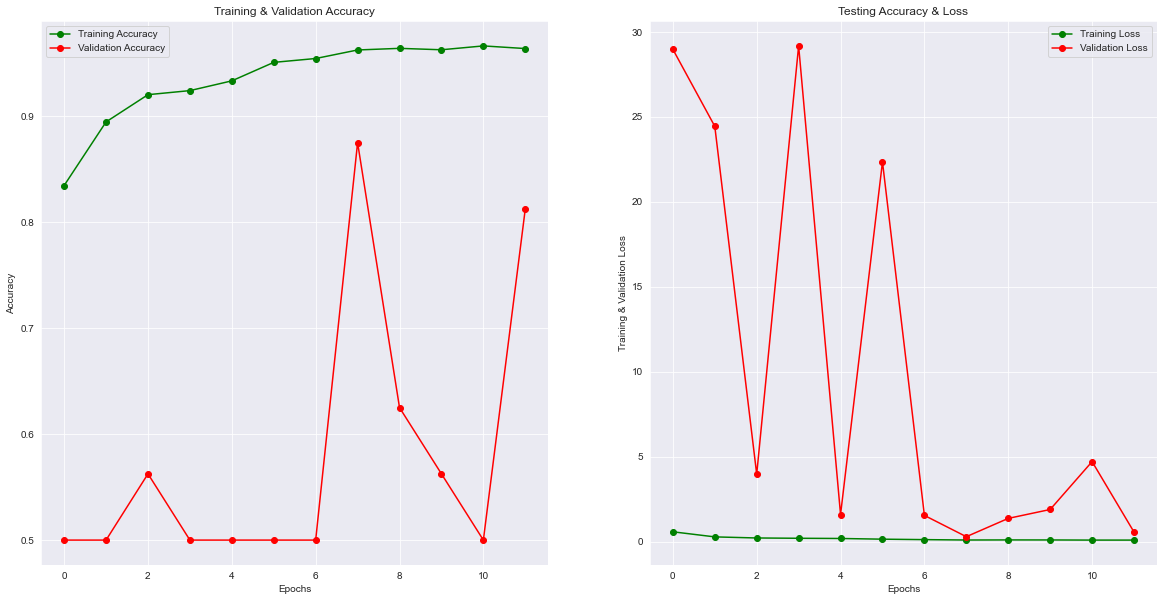

In [14]:
# Analysis after Model Training
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [15]:
model.save('./pnemonia_prediction.model')

INFO:tensorflow:Assets written to: ./pnemonia_prediction.model\assets
